<a id="top"></a>
# UN SDG Indicator 15.3.1:<br> Proportion of Land That Is Degraded over Total Land Area


<hr>

# Definitions

> **Land degradation** is defined as the reduction or loss of the biological or economic productivity and complexity of rain fed cropland, irrigated cropland, or range, pasture, forest and woodlands resulting from a combination of pressures, including land use and management practices. This definition was adopted by and is used by the 196 countries that are Party to the UNCCD.<sup>1</sup>

> **Total land area** is the total surface area of a country excluding the area covered by inland waters, like major rivers and lakes.<sup>2</sup>

<sup>1</sup> United Nations Convention to Combat Desertification. 1994. Article 1 of the Convention Text http://www2.unccd.int/sites/default/files/relevant-links/2017-01/UNCCD_Convention_ENG_0.pdf

<sup>2</sup> Food and Agriculture Organization of the United Nations

<hr>

# Notebook Summary
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 15.3.1 - the proportion of land that is degraded over total land area.

The land classification dataset used is the FROM-GLC dataset, which has a resolution of 30 meters, which is much higher than the 300 meter resolution of the default dataset for UN SDG 15.3.1 according to the [Good Practice Guidance document](https://www.unccd.int/sites/default/files/relevant-links/2017-10/Good%20Practice%20Guidance_SDG%20Indicator%2015.3.1_Version%201.0.pdf)- the ESA CCI LC dataset.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load the Data](#load_data)
    * [Load Land Classification Data from FROM-GLC](#load_land_class_data)
    * [Load EO Data from the Datacube](#load_data_cube)
* [Train Random Forest Classifier](#train_cls)
    * [Train Model](#train_model)
    * [Get Model Score and  Predictions](#get_score_pred)
    * [Prepare for Visualization](#prepare_vis)
    * [Visualize Land Class Data for the Beginning and End of the Time Range](#vis_ESA_CCI)
    * [Visualize Predicted Land Classes (from Model) and "True" Land Classes](#vis_pred_true_land_cls)
* [Visualize Land Change Frequency](#land_change_freq)
* [Create Change Matrix](#change_matrix)
* [Calculate Peak NDVI Within Classes](#peak_ndvi_within_class)
* [Determine NDVI Trend](#ndvi_trend)
    * [Fit a Thiel-Sen Regressor to the Mean NDVI Across Time](#thiel_sen_reg)
    * [Run the Mann-Kendall Test on the Mean NDVI Across Time to Determine the Trend](#mann_kendall_test)
    
# Data  Retrieval
The FROM-GLC data should be indexed by the Data Cube on this machine before running this notebook. Contact a system administrator if there is no Data Cube product containing FROM-GLC data for your area of interest.

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span> 

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt

# Allow importing of our utilities.
import sys
sys.path.append("..")

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
import datetime as dt
import numpy as np
import xarray as xr

# PLotting settings
default_fontsize = 14
plt.rcParams['font.size'] = default_fontsize

/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/psycopg2-2.7.6.1-py3.6-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create an instance of the datacube and API.
api = DataAccessApi(config="/home/localuser/.datacube.conf")
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [3]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [4]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


**Choose products**

In [5]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.
use_Landsat7 = True
use_Landsat8 = False
platforms = []
products = []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_ledaps_ghana')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_lasrc_ghana')

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_load import get_overlapping_area

# Get the area common to all products.
full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)
# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

**Specify start and end dates**

In [7]:
print("Start and end dates available to both products:")
for platform, min_max_date in zip(platforms, min_max_dates):
    print("{}:\n{}".format(platform, min_max_date))

Start and end dates available to both products:
LANDSAT_7:
[datetime.datetime(2000, 1, 1, 10, 19, 16)
 datetime.datetime(2019, 1, 30, 10, 15, 46)]


**Specify an area to analyze**

In [8]:
# Specify latitude and longitude bounds of an interesting area within the full extents.

## Ghana
# lat_small = (6.5016, 6.5821) # Lake Volta (WOFS Test)
# lon_small = (-0.1618, -0.055) # Lake Volta (WOFS Test)
# lat_small = (6.5138, 6.5292) # Lake Volta (WOFS Test - small)
# lon_small = (-0.1669, -0.1493) # Lake Volta (WOFS Test - small)
# lat_small = (10.0, 11.0) # NE Ghana (Land Change)
# lon_small = (-0.9, -0.1) # NE Ghana (Land Change)
# lat_small = (10.45, 10.55) # NE Ghana (Land Change - small)
# lon_small = (-0.55, -0.45) # NE Ghana (Land Change - small)
# lat_small = (10.50, 10.55) # NE Ghana (Land Change - very small)
# lon_small = (-0.50, -0.45) # NE Ghana (Land Change - very small)
# lat_small = (5.3180, 5.5500) # S Ghana (Land Change - #2)
# lon_small = (-0.6505,-0.4110) # S Ghana (Land Change - #2)

# lat_small = (5.4500, 5.7500) # S Ghana (Land Change - #3 - Accra)
# lon_small = (-0.3250, 0.0000) # S Ghana (Land Change - #3 - Accra)

# lat_small = (5.4500, 5.6500) # S Ghana (Land Change - #3 - Kasoa - small)
# lon_small = (-0.5500, -0.3250) # S Ghana (Land Change - #3 - Kasoa - small)
# lat_small = (5.2500, 6.0000) # S Ghana (Land Change - #4)
# lon_small = (-2.0000, 1.0000) # S Ghana (Land Change - #4)
lat_small = (6.5500, 6.8000) # S Ghana (Land Change - #3 - Kumasi - small)
lon_small = (-1.7500, -1.5000) # S Ghana (Land Change - #3 - Kumasi - small)
# lat_small = (6.5500, 6.6000) # S Ghana (Land Change - #3 - Kumasi - very small)
# lon_small = (-1.6000, -1.5500) # S Ghana (Land Change - #3 - Kumasi - very small)

## Vietnam
# Can Tho
# min_lat_small, max_lat_small = (9.9795, 10.1000)
# min_lon_small, max_lon_small = (105.7058, 105.8058)
# Ho Chi Minh City
# min_lat_small, max_lat_small = (10.6452, 10.8452)
# min_lon_small, max_lon_small = (106.5994, 106.7994)
# Phu Thuy
# lat_small = (10.8945, 10.9679)
# lon_small = (108.0616, 108.1460)

**Visualize the selected area**

In [9]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(lat_small, lon_small)

## <span id="load_data">Load the Data [&#9652;](#top)</span>

### <span id="load_land_class_data">Load Land Classification Data from FROM-GLC [&#9652;](#top)</span>

In [10]:
from utils.data_cube_utilities.dc_time import _n64_to_datetime
from utils.data_cube_utilities.dc_load import is_dataset_empty

# Only data for the first and last years should be loaded.
land_cls_data = dc.load(product='from_glc_ghana', lat=lat_small, lon=lon_small, 
                        measurements=['land_class'])
assert not is_dataset_empty(land_cls_data), "No data was retrieved."
land_cls_data = land_cls_data['land_class']
# The first and last years of the land classification data define the range of years to load Data Cube data for.
land_cls_years = [_n64_to_datetime(time).year for time in land_cls_data.time.values]
first_year, last_year = land_cls_years[0], land_cls_years[1]
years = np.arange(first_year,last_year+1)
date_ranges = {year: [dt.datetime(year,1,1), dt.datetime(year,12,31)] for year in years}
# Set the times to the years as integers.
land_cls_data.time.values = land_cls_years

### <span id="load_data_cube">Load EO Data from the Datacube [&#9652;](#top)</span>

In [11]:
from utils.data_cube_utilities.dc_load import match_dim_sizes, find_desired_acq_inds, \
                                                      reduce_on_day
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.aggregate import xr_scale_res
from utils.data_cube_utilities.sort import xarray_sortby_coord
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
from utils.data_cube_utilities.dc_utilities import ignore_warnings
from utils.data_cube_utilities.vegetation import NDVI

datacube_median_data = [None]*len(years) # Yearly median composites.
datacube_ndvi_data = [None]*len(years) # Yearly average NDVI.
year_inds_no_data = [] # A list of indices into the above lists for years with no data.
measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
for year_ind, date_range in enumerate(date_ranges.values()):
    # First, load and combine the data.
    datasets = {}
    clean_masks = {}
    for platform, product in zip(platforms, products):
        # Load the dataset.
        dataset = dc.load(platform=platform, product=product, lat=lat_small, lon=lon_small, 
                          time=date_range, measurements=measurements)
        if len(dataset.dims) == 0: # The dataset is empty.
            continue
        # Ensure the Data Cube data has the same shape as the land classification data.
        dataset = ignore_warnings(xr_scale_res, dataset, 
                                  abs_res=(len(land_cls_data.longitude), len(land_cls_data.latitude)))
        # Get the clean mask.
        clean_mask = landsat_qa_clean_mask(dataset, platform) & (dataset[measurements[0]] != -9999) & \
            landsat_clean_mask_invalid(dataset)
        # Remove the 'pixel_qa' data variable since we have the clean mask.
        dataset = dataset.drop('pixel_qa')    
        # Clean the data.
        dataset = dataset.where(clean_mask)
        datasets[product], clean_masks[product] = dataset, clean_mask
    del dataset, clean_mask
    # Combine everything.
    if len(datasets) > 0:
        dataset = xarray_sortby_coord(xr.concat(list(datasets.values()), dim='time'), coord='time')
        clean_mask = xarray_sortby_coord(xr.concat(list(clean_masks.values()), dim='time'), coord='time')
        datacube_ndvi_data[year_ind] = NDVI(dataset.mean(dim=['latitude', 'longitude', 'time']))
        datacube_median_data[year_ind] = create_median_mosaic(dataset, clean_mask)
    else:
        year_inds_no_data.append(year_ind)
        dataset = xr.Dataset()
        clean_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
    del datasets, clean_masks

In [12]:
year_inds_with_data = np.setdiff1d(np.arange(len(years)), year_inds_no_data)
years_with_data = years[year_inds_with_data]
first_year_with_data, last_year_with_data = years_with_data[[0,-1]]

In [13]:
if len(year_inds_no_data) > 0:
    # If all years, the first year, or the last year are missing, the first and last years selected must be changed.
    assert_msg_begin = "The selected combination of platforms, products, and extents have no data "
    assert_msg_end = " The first and last years with data available are {} and {}."\
                     .format(first_year_with_data, last_year_with_data)
    # Whether the first and last selected years have data.
    first_year_has_data, last_year_has_data = year_inds_no_data[0] != 0, year_inds_no_data[-1] != len(years)-1
    assert len(year_inds_no_data) != len(years), assert_msg_begin + "for any of the selected years." + assert_msg_end
    assert first_year_has_data or last_year_has_data, assert_msg_begin + "for the first and last selected years." + assert_msg_end
    assert first_year_has_data, assert_msg_begin + "for the first selected year." + assert_msg_end
    assert last_year_has_data, assert_msg_begin + "for the last selected year." + assert_msg_end

In [14]:
# For years which have no data and are between the first and last years, 
# shape them as the other years, but fill with NaNs.
median_data_first_year_avail = datacube_median_data[year_inds_with_data[0]]
median_data_full_NaNs = xr.full_like(median_data_first_year_avail, np.nan, dtype=np.float64)
ndvi_data_first_year_avail = datacube_ndvi_data[year_inds_with_data[0]]
ndvi_data_NaN = xr.full_like(ndvi_data_first_year_avail, np.nan, dtype=np.float64) 
for year_ind in year_inds_no_data:
    datacube_median_data[year_ind] = median_data_full_NaNs
    datacube_ndvi_data[year_ind] = ndvi_data_NaN

In [15]:
datacube_ndvi_data = xr.concat(datacube_ndvi_data, dim='time')
datacube_ndvi_data.coords['time'] = years
datacube_median_data = xr.concat(datacube_median_data, dim='time')
datacube_median_data.coords['time'] = years

## <span id="train_cls">Train Random Forest Classifier [&#9652;](#top)</span>

### <span id='train_model'>Train Model [&#9652;](#top)</span>

In [16]:
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

from utils.data_cube_utilities.dc_utilities import reverse_array_dict

# For the feature matrix, make one row for the band values for each pixel for each year.
datacube_median_data_arr = datacube_median_data.sel(time=[first_year, last_year]).to_array(dim='data_var').\
                           transpose('time', 'latitude', 'longitude', 'data_var').values
num_data_vars = datacube_median_data_arr.shape[-1]

# Encode data as 6 IPCC land categories.
# See the classification system tables for these codes and their more detailed meanings:
# http://data.ess.tsinghua.edu.cn/
land_cls_values_for_label = OrderedDict([ # For a label, returns all corresponding land class values.
    ('Forest Land', np.array(list(range(20,30)))),
    ('Grassland', np.array(list(range(30,50)) + list(range(70,80)))),
    ('Cropland', np.array(list(range(10,20)))),
    ('Wetlands', np.array(list(range(50,60)))),
    ('Settlements', np.array(list(range(60,70)) + list(range(80, 90)))),
    ('Other Land', np.array(list(range(90,110)))),
    ('No Data', np.array([120]))
])
# For a land class value, returns the corresponding label.
land_cls_label_for_value = reverse_array_dict(land_cls_values_for_label)

# Encode the data.
land_cls_data_encoded = land_cls_data.copy()
for i, (cls_label, values_for_label) in enumerate(land_cls_values_for_label.items()):
    land_cls_data_encoded.values[np.isin(land_cls_data.values, values_for_label)] = i

land_cls_data_arr_encoded = land_cls_data_encoded.transpose('time', 'latitude', 'longitude').values
# Obtain a version of `land_cls_data_encoded` for visualization by 
# setting pixels without valid land class data to NaN.
land_cls_data_encoded_vis = land_cls_data_encoded.astype(np.float32)
land_cls_data_encoded_vis = land_cls_data_encoded_vis.where(land_cls_data_encoded_vis != 6, np.nan)

In [17]:
# Flatten the land class data to use as class labels.
land_cls_data_arr_encoded_flat = land_cls_data_arr_encoded.flatten()
# Select only pixels which have valid land class data.
valid_land_cls_mask = land_cls_data_arr_encoded_flat != 6
y_pred = np.empty_like(land_cls_data_arr_encoded_flat, dtype=np.float32)

X, y = datacube_median_data_arr, land_cls_data_arr_encoded_flat
X = X.reshape((-1, X.shape[-1]))
# Remove corresponding entries in `X` and `y` where either has NaN values.
no_nan_mask = (~np.isnan(X).any(axis=1)) & ~np.isnan(y)
clean_model_data_mask = no_nan_mask & valid_land_cls_mask
X_clean, y_clean = X[clean_model_data_mask], y[clean_model_data_mask]

param_grid = {
    'n_estimators': [50]
}
num_folds = 5
grid_search = GridSearchCV(RandomForestClassifier(), param_grid,
                           scoring=make_scorer(accuracy_score), 
                           cv=num_folds, n_jobs=-1)
grid_search.fit(X_clean, y_clean)
model, score, best_params = grid_search.best_estimator_, grid_search.best_score_, grid_search.best_params_

In [18]:
print("The best parameter set was:", best_params)

The best parameter set was: {'n_estimators': 50}


### <span id='get_score_pred'>Get Model Score and Predictions [&#9652;](#top)</span>

In [19]:
# Make predictions.
y_pred_clean = model.predict(X_clean)

# Evaluate performance.
print("Model Cross Validation Score: {0:0.6%} (Stratified {1}-fold)".format(score, num_folds))
print("Model Accuracy: {0:0.6%}".format(accuracy_score(y_clean, y_pred_clean)))

Model Cross Validation Score: 63.987429% (Stratified 5-fold)
Model Accuracy: 99.859634%


### <span id='prepare_vis'>Prepare for Visualization [&#9652;](#top)</span>

In [20]:
from utils.data_cube_utilities.plotter_utils import \
    figure_ratio, xarray_imshow, create_discrete_color_map

# Determine the class labels to use in visualizations.
land_cls_values_for_label_copy = land_cls_values_for_label.copy()
land_cls_values_for_label_copy.pop('No Data', None)
classes = np.array(list(land_cls_values_for_label_copy.keys()))
num_classes = len(classes)

# Reshape land class predictions for visualization.
y_pred[clean_model_data_mask] = y_pred_clean
y_pred[~clean_model_data_mask] = np.nan
dim_lengths_shape = land_cls_data_encoded.shape
y_pred_3D = xr.DataArray(data=y_pred.reshape(dim_lengths_shape), coords=land_cls_data_encoded.coords, 
                         dims=land_cls_data_encoded.dims, attrs=land_cls_data_encoded.attrs)

# Gets figure sizes for plotting geospatial data.
def get_figsize_geospatial(fixed_width=6, fixed_height=None, 
                           num_cols=1, num_rows=1):
    return figure_ratio(datacube_median_data, 
                        fixed_width=fixed_width, fixed_height=fixed_height,
                        num_cols=num_cols, num_rows=num_rows)

# Get a mapping of values to labels for legend labelling.
legend_labels = {value:label for value, label in enumerate(classes)}
legend_values = list(legend_labels.keys())

# Create a colormap for the predicted and true land classes.
map_cmap = create_discrete_color_map((0, len(classes)-1), 
                                 colors=['red', 'yellow', 'green', 'blue', 'brown', 'black'])
# Create a colormap for coloring the cells in the change matrix.
change_matrix_cmap = create_discrete_color_map([-1,1], colors=[(255, 204, 204), (189, 215, 238), (198, 224, 180)])

title_fontdict = dict(fontsize=20) # Title formatting
tick_label_fmt_dict = dict(axis='both', labelsize=12) # Tick label formatting
axis_label_fmt_dict = dict(fontsize=16) # Axis label formatting
legend_kwargs = dict(fontsize=12, framealpha=0.4)

### <span id='vis_ESA_CCI'>Visualize Land Class Data for the Beginning and End of the Time Range [&#9652;](#top)</span>

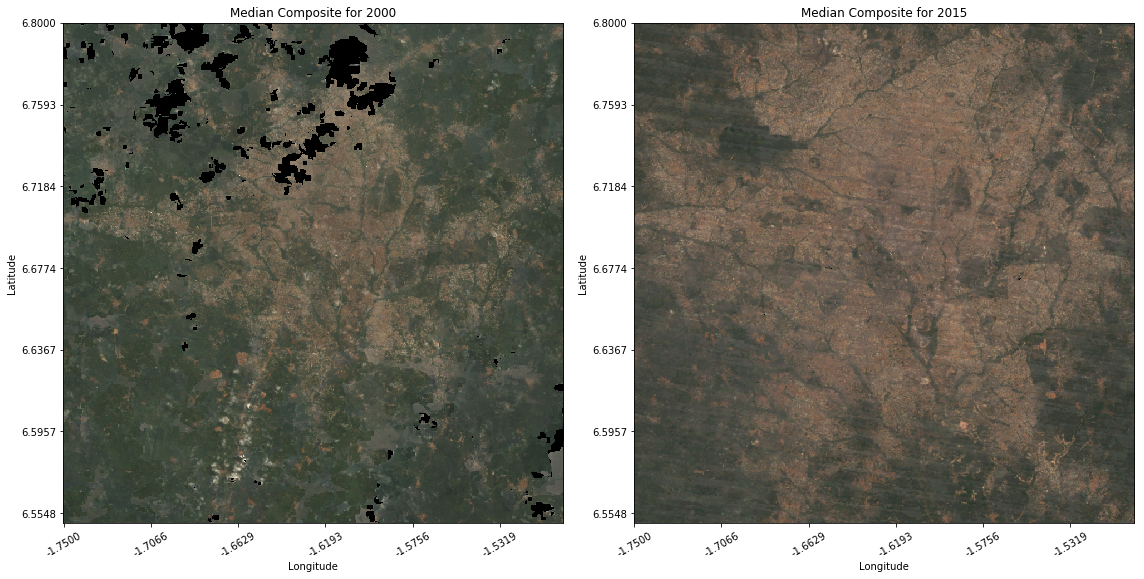

In [21]:
from utils.data_cube_utilities.dc_rgb import rgb

num_rows, num_cols = 1, 2
figsize = get_figsize_geospatial(fixed_width=8, num_cols=num_cols, num_rows=num_rows)
fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
fig, ax[0] = rgb(datacube_median_data.sel(time=first_year), fig=fig, ax=ax[0],
                 use_data_min=True, use_data_max=True)
ax[0].set_title("Median Composite for {}".format(first_year))
fig, ax[1] = rgb(datacube_median_data.sel(time=last_year), fig=fig, ax=ax[1],
                 use_data_min=True, use_data_max=True)
ax[1].set_title("Median Composite for {}".format(last_year))
plt.tight_layout()
plt.show()

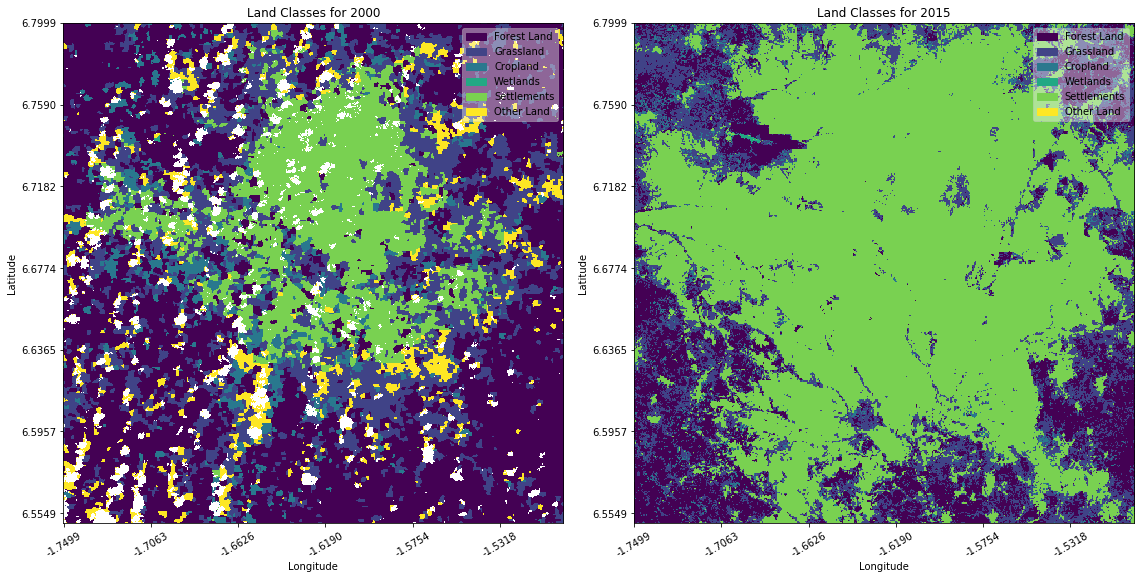

In [22]:
from utils.data_cube_utilities.plotter_utils import xarray_imshow

# Show true land classes for the first and last years.
num_rows, num_cols = 1, 2
figsize = get_figsize_geospatial(fixed_width=8, num_cols=num_cols, num_rows=num_rows)
fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
fig, ax[0], im, cbar = \
xarray_imshow(land_cls_data_encoded_vis.sel(time=first_year), fig=fig, ax=ax[0],
              use_colorbar=False, use_legend=True,
              legend_labels=legend_labels,
              title="Land Classes for {}".format(first_year),
              possible_plot_values=legend_values)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
fig, ax[1], im, cbar = \
    xarray_imshow(land_cls_data_encoded_vis.sel(time=last_year), fig=fig, ax=ax[1],
                  use_colorbar=False, use_legend=True,
                  legend_labels=legend_labels,
                  title="Land Classes for {}".format(last_year),
                  possible_plot_values=legend_values)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
plt.tight_layout()
plt.show()

### <span id='vis_pred_true_land_cls'>Visualize Predicted Land Classes (from Model) and "True" Land Classes [&#9652;](#top)</span>

**Note that white pixels in the predicted figure are due to missing or masked data, which includes regions occluded by clouds.**

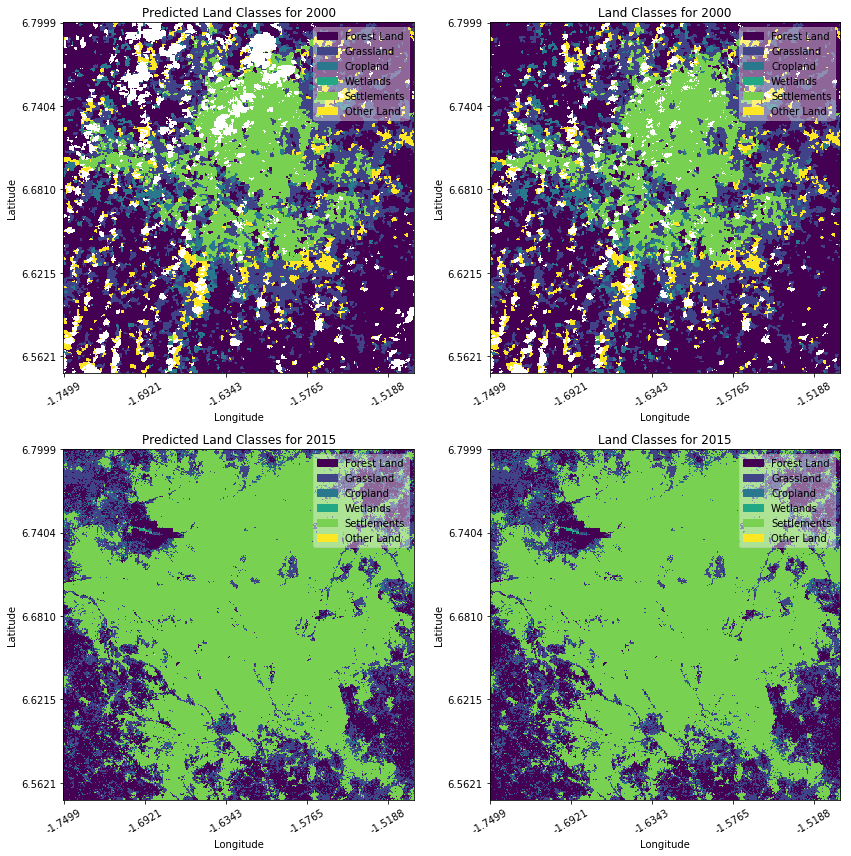

In [23]:
# Show predicted and true land classes side-by-side for some years.
years_to_show = years[0], years[-1] # Select the years you wish to examine.
for year in years_to_show:
    assert year in years, \
        "The year {} has not been loaded. Only include years "\
        "in the variable 'years_to_show' which are also in the variable 'years'.".format(year)

num_rows, num_cols = len(years_to_show), 2
figsize = get_figsize_geospatial(num_cols=num_cols, num_rows=num_rows)
fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize)#, dpi=std_dpi)
for year_ind, year in enumerate(years_to_show):
    # Show the predicted land classes on the left.
    fig, ax[year_ind,0], im, cbar = \
        xarray_imshow(y_pred_3D[year_ind], fig=fig, ax=ax[year_ind,0], 
                      use_colorbar=False, use_legend=True,
                      legend_labels=legend_labels,
                      title="Predicted Land Classes for {}".format(year),
                      possible_plot_values=legend_values)
    ax[year_ind, 0].set_xlabel('Longitude')
    ax[year_ind, 0].set_ylabel('Latitude')
    # Show the true land classes on the right.
    fig, ax[year_ind,1], im, cbar = \
        xarray_imshow(land_cls_data_encoded_vis.sel(time=year), fig=fig, ax=ax[year_ind,1], 
                      use_colorbar=False, use_legend=True,
                      legend_labels=legend_labels,
                      title="Land Classes for {}".format(year),
                      possible_plot_values=legend_values)
    ax[year_ind, 1].set_xlabel('Longitude')
    ax[year_ind, 1].set_ylabel('Latitude')
plt.tight_layout()
plt.show()

## <span id="land_change_freq">Visualize Land Change Frequency [&#9652;](#top)</span>

In [24]:
# Get the number of class changes for each pixel between the first and last years.
example_xr = land_cls_data.isel(time=0)
num_cls_changes = xr.DataArray(data=np.zeros_like(example_xr), coords=example_xr.coords, 
                               dims=example_xr.dims, attrs=example_xr.attrs).astype(np.int8)
for time_ind in range(1, len(land_cls_data_encoded.time)):
    prev_classes = land_cls_data_encoded.isel(time=time_ind-1)
    current_classes = land_cls_data_encoded.isel(time=time_ind)
    cls_changes = (current_classes != prev_classes).astype(np.int8)
    num_cls_changes += cls_changes
unq_num_cls_changes = np.unique(num_cls_changes.values)

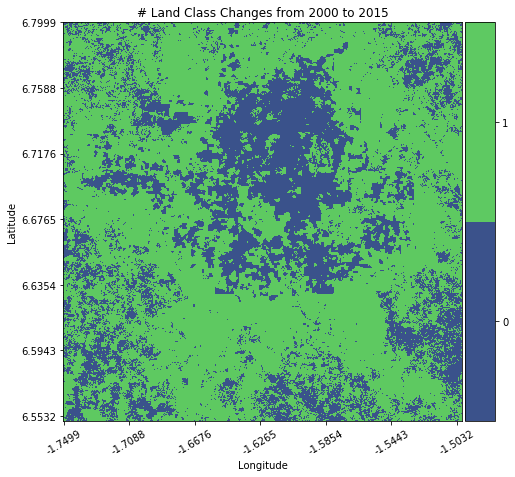

In [25]:
pts_fmt = [None]*len(unq_num_cls_changes)
cmap = create_discrete_color_map([min(unq_num_cls_changes),max(unq_num_cls_changes)], 
                                 pts=unq_num_cls_changes, cmap='viridis', pts_fmt=pts_fmt)

figsize = get_figsize_geospatial()
fig = plt.figure(figsize=figsize)
fig, ax, im, cbar = \
    xarray_imshow(num_cls_changes, fig=fig, cbar_labels=unq_num_cls_changes, 
                  imshow_kwargs=dict(cmap=cmap), cbar_kwargs=dict(ticks=pts_fmt),
                  title="# Land Class Changes from {} to {}".format(first_year, last_year))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

## <span id="change_matrix">Create Change Matrix [&#9652;](#top)</span>

**To specify what transitions are considered positive, neutral, or negative, alter `pos_neu_neg_cng_mat` in the code cell below**

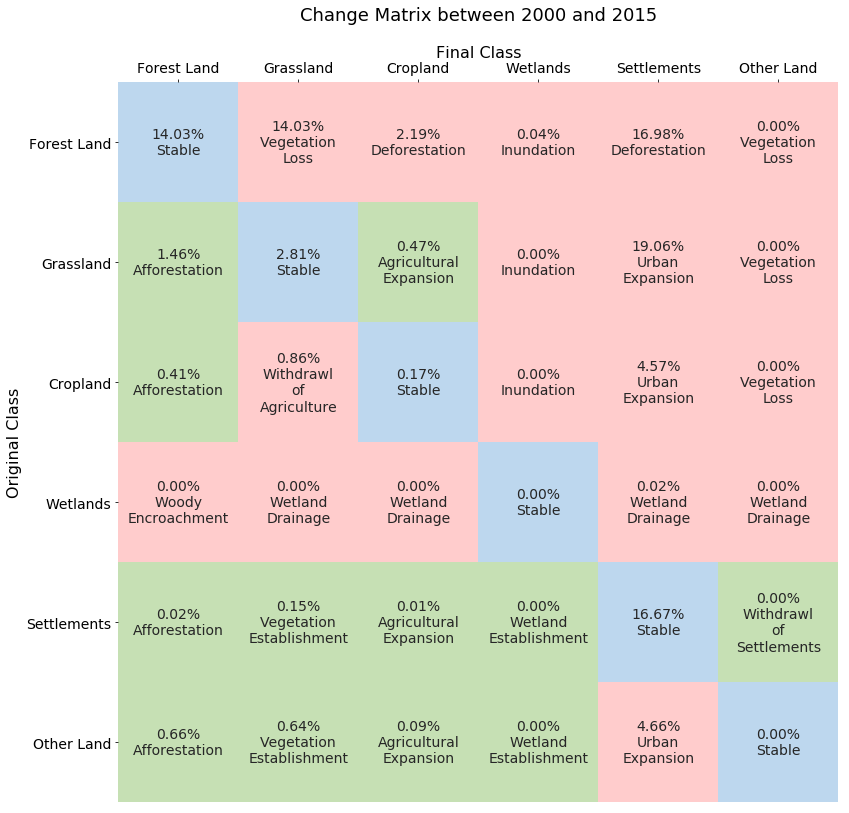

In [26]:
from utils.data_cube_utilities.plotter_utils import print_matrix

# Get class values for the first and last year.
original_year_classes = land_cls_data_encoded.sel(time=first_year).\
                        transpose('latitude', 'longitude').values.flatten()
final_year_classes = land_cls_data_encoded.sel(time=last_year).\
                     transpose('latitude', 'longitude').values.flatten()

# Select only pixels which have valid land class data.
valid_mask = (original_year_classes != 6) & (final_year_classes != 6)
original_year_classes, final_year_classes = \
    original_year_classes[valid_mask], final_year_classes[valid_mask]

# Get 2-tuples of (original_class, final_class), fill out the change matrix,then convert to percentages of total pixels.
original_final_cls = np.stack([original_year_classes, final_year_classes], axis=1)
change_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
for orig_cls, final_cls in original_final_cls:
    change_matrix[orig_cls, final_cls] += 1
change_matrix = change_matrix / change_matrix.sum()

# IMPORTANT: This is a matrix specifying each land class transition as positive (1 - green), 
#            neutral (0 - blue), or negative (-1 - red). Original classes are indexed by row and
#            final classes are indexed by column.
neg_cng_val, neu_cng_val, pos_cng_val = -1, 0, 1
pos_neu_neg_cng_mat = np.array([
    # Forest Land  Grassland  Cropland  Wetlands  Settlements  Other Land
    [        0,        -1,        -1,        -1,        -1,        -1], # Forest Land
    [        1,         0,         1,        -1,        -1,        -1], # Grassland 
    [        1,        -1,         0,        -1,        -1,        -1], # Cropland 
    [       -1,        -1,        -1,         0,        -1,        -1], # Wetlands
    [        1,         1,         1,         1,         0,         1], # Settlements
    [        1,         1,         1,         1,        -1,         0]  # Other Land    
])

# Create mappings of transitions to values for coloring based on a colormap.
cls_trans_for_value = {pos_cng_val:[], neu_cng_val:[], neg_cng_val:[]}
for i, orig_class in enumerate(classes):
    for j, final_class in enumerate(classes):
        pos_neu_neg_cng_val = pos_neu_neg_cng_mat[i,j]
        cls_trans_for_value[pos_neu_neg_cng_val].append((orig_class, final_class))
value_for_cls_trans = reverse_array_dict(cls_trans_for_value)

# Create mappings of transitions to transition type labels (e.g. "Afforestation").
cls_trans_for_label = {
    "Stable": [('Forest Land', 'Forest Land'), ('Grassland', 'Grassland'),
               ('Cropland', 'Cropland'), ('Wetlands', 'Wetlands'),
               ('Settlements', 'Settlements'), ('Other Land', 'Other Land')],
    "Vegetation Loss": [('Forest Land', 'Grassland'), ('Forest Land', 'Other Land'),
                        ('Grassland', 'Other Land'), ('Cropland', 'Other Land')],
    "Deforestation": [('Forest Land', 'Cropland'), ('Forest Land', 'Settlements'), 
                      ],
    "Inundation": [('Forest Land', 'Wetlands'), ('Grassland', 'Wetlands'), 
                   ('Cropland', 'Wetlands')],
    "Afforestation": [('Grassland', 'Forest Land'), ('Cropland', 'Forest Land'),
                      ('Settlements', 'Forest Land'), ('Other Land', 'Forest Land')],
    "Agricultural Expansion": [('Grassland', 'Cropland'), ('Settlements', 'Cropland'),
                               ('Other Land', 'Cropland')],
    "Urban Expansion": [('Grassland', 'Settlements'), ('Cropland', 'Settlements'),
                        ('Other Land', 'Settlements')],
    "Withdrawl of Agriculture": [('Cropland', 'Grassland')],
    "Woody Encroachment": [('Wetlands', 'Forest Land')],
    "Wetland Drainage": [('Wetlands', 'Grassland'), ('Wetlands', 'Cropland'), 
                         ('Wetlands', 'Settlements'), ('Wetlands', 'Other Land')],
    "Vegetation Establishment": [('Settlements', 'Grassland'), ('Other Land', 'Grassland')],
    "Wetland Establishment": [('Settlements', 'Wetlands'), ('Other Land', 'Wetlands')],
    "Withdrawl of Settlements": [('Settlements', 'Other Land')],
}
cls_label_for_trans = reverse_array_dict(cls_trans_for_label)

# Create the cell value matrix (used to color cells).
cell_value_mtx = np.empty_like(change_matrix)
for i, cls_label1 in enumerate(classes):
    for j, cls_label2 in enumerate(classes):
        cell_value_mtx[i,j] = value_for_cls_trans[(cls_label1, cls_label2)]
        
# Create the cell label matrix.
cell_label_mtx = np.empty_like(change_matrix, dtype=object)
for i, cls_label1 in enumerate(classes):
    for j, cls_label2 in enumerate(classes):
        cell_label_mtx[i,j] = \
            "{0:.2%}\n{1}".format(change_matrix[i,j], 
                                  cls_label_for_trans[(cls_label1, cls_label2)].replace(" ", "\n"))

# Show the change matrix
fig = plt.figure(figsize=(10,10))
fig, ax = print_matrix(cell_value_mtx=cell_value_mtx, cell_label_mtx=cell_label_mtx, 
                       row_labels=classes, col_labels=classes, cmap=change_matrix_cmap, 
                       cell_val_fmt='s', annot_kwargs=dict(size=14), 
                       x_axis_tick_kwargs=dict(rotation=0), x_axis_ticks_position='top', fig=fig)
ax.yaxis.set_label_position('left')
plt.ylabel('Original Class', fontsize=16)
ax.xaxis.set_label_position('top')
plt.xlabel('Final Class', fontsize=16)
plt.title('Change Matrix between {} and {}'.format(first_year, last_year), fontsize=18, pad=25)
plt.show()

## <span id="peak_ndvi_within_class">Calculate Peak NDVI Within Classes [&#9652;](#top)</span>

In [27]:
# Get class values for the first and last year.
datacube_original_year_data_arr = NDVI(datacube_median_data.sel(time=first_year)[['nir', 'red']]).\
                                  transpose('latitude', 'longitude').values.flatten()[valid_mask]
datacube_final_year_data_arr = NDVI(datacube_median_data.sel(time=last_year)[['nir', 'red']]).\
                               transpose('latitude', 'longitude').values.flatten()[valid_mask]
    
# Calculate the maximum NDVI for all pixels that are the same class in the first and final years.
max_ndvi_per_class = np.zeros(num_classes)
for i in range(num_classes):
    stable_mask = np.all(original_final_cls == i, axis=1)
    class_ndvi_vals = datacube_original_year_data_arr[stable_mask]
    max_ndvi_per_class[i] = np.nanmax(class_ndvi_vals) if len(class_ndvi_vals) > 0 else np.nan

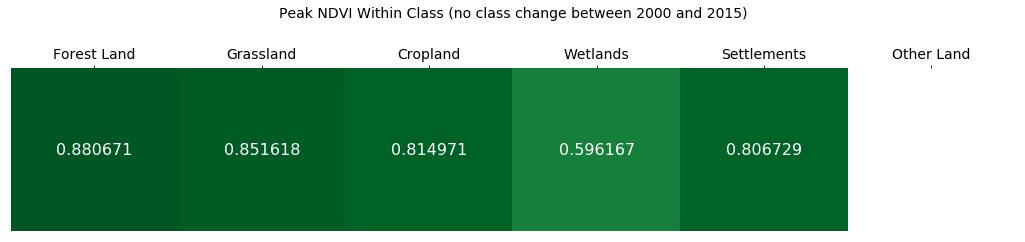

In [28]:
plt.rcParams['font.size'] = 16 # Set the font size for this plot..

width = min(18, 3*num_classes)
height = width/num_classes
print_matrix(max_ndvi_per_class.reshape(1,-1), show_row_labels=False, 
             col_labels=classes, cmap='Greens', x_axis_tick_kwargs=dict(rotation=0), 
             x_axis_ticks_position='top', heatmap_kwargs=dict(vmin=-1, vmax=1), 
             fig_kwargs=dict(figsize=(width,height)))
plt.title('Peak NDVI Within Class (no class change between {} and {})'.format(first_year, last_year), 
          fontsize=14, pad=30)
plt.show()

plt.rcParams['font.size'] = default_fontsize

## <span id="ndvi_trend">Determine NDVI Trend [&#9652;](#top)</span>

### <span id='thiel_sen_reg'>Fit a Thiel-Sen Regressor to the Mean NDVI Across Time [&#9652;](#top)</span>

In [29]:
regressor_y = datacube_ndvi_data.values
regressor_time_pre_fmt = datacube_ndvi_data.time.values
regressor_time = regressor_time_pre_fmt.reshape(-1,1)

from sklearn.linear_model import TheilSenRegressor
regressor = TheilSenRegressor().fit(regressor_time, regressor_y)

### <span id='mann_kendall_test'>Run the Mann-Kendall Test on the Mean NDVI Across Time to Determine the Trend [&#9652;](#top)</span>

In [30]:
def mann_kendall_test(t, x):
    """
    Runs the Mann-Kendall test to determine a trend in time series data.
    
    This function is a modified form of the function defined here:
        https://up-rs-esp.github.io/mkt/_modules/mkt.html#test
    Documentation used includes: 
        https://up-rs-esp.github.io/mkt/

    Parameters
    ----------
    t : 1D numpy.ndarray
        Array of the time points of measurements.
    x : 1D numpy.ndarray
        Array containing the measurements corresponding to entries of 't'.

    Returns
    -------
    Z_mk: float
        The Z-score statistic for the Mann-Kendall test.
    """
    # Calculate signs of all possible differences x_j - x_k, where j > k.
    n = len(t)
    sgn = np.full(int((n-1)*n/2), 10)
    ind = 0
    for j in range(n-1):
        sgn[ind:ind+(n-1-j)] = np.sign(x[j+1:] - x[j])
        ind += n-1-j
    
    # Calculate the mean of the signs of the differences.
    S_mean = sgn.sum()
    
    # Calculate the variance of the signs of the differences.
    unique_x = np.unique(x)
    num_tie_groups = len(unique_x)
    tie_coef = 0
    if num_tie_groups < len(x): # Calculate the tie group coefficient.
        for tie_ind in range(num_tie_groups):
            tie_val = unique_x[tie_ind]
            n_t_g = len(x[x==tie_val]) # The number of ties for this tie group.
            tie_coef += n_t_g*(n_t_g-1)*(2*n_t_g+5)
    varS = (n*(n-1)*(2*n+5) - tie_coef)/18
    
    # Compute the Z-score based on above estimated mean and variance
    if S_mean > 0:
        Z_mk = (S_mean-1)/np.sqrt(varS)
    if S_mean == 0:
        Z_mk = 0
    if S_mean < 0:
        Z_mk = (S_mean+1)/np.sqrt(varS)
    
    return Z_mk

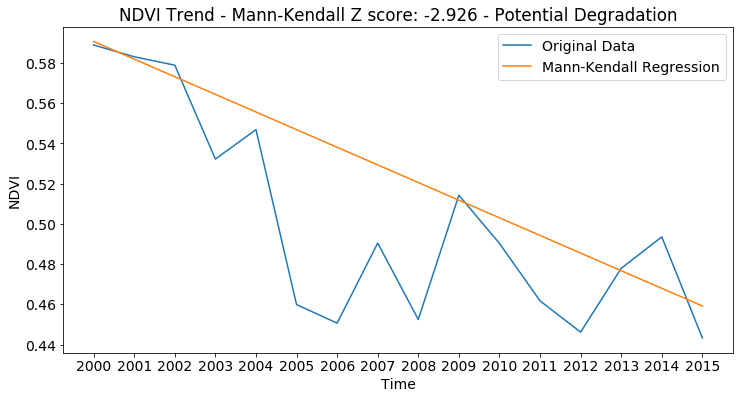

In [31]:
z_score = mann_kendall_test(regressor_time_pre_fmt, regressor_y)

z_score_label = None
if z_score < -1.96:
    z_score_label = "Potential Degradation"
if (-1.96 < z_score) and (z_score < 1.96):
    z_score_label = "No Significant Change"
if 1.96 < z_score:
    z_score_label = "Potential Improvement"

plt.figure(figsize=(12,6))
plt.plot(regressor_time_pre_fmt, regressor_y, label='Original Data')
plt.plot(regressor_time_pre_fmt, regressor.predict(regressor_time), label='Mann-Kendall Regression')
plt.legend()
plt.title("NDVI Trend - Mann-Kendall Z score: {:.3f} - {}".format(z_score, z_score_label))
plt.xticks(regressor_time_pre_fmt)
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.show()